In [100]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, log_loss, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier

In [101]:
df = pd.read_csv('./../data/preprocessed_matches.csv')
df.head()

,match_id,season,kickoff,home_team,home_team_id,home_score,away_team,away_team_id,away_score,outcome_label,...,home_pts_roll,away_gf_roll,away_ga_roll,away_pts_roll,h2h_avg_points_home,h2h_avg_points_away,rest_days_home,rest_days_away,rest_days_diff,target
0,803169,2015,2015-08-08 12:45:00,Manchester United,1,1,Tottenham Hotspur,6,0,H_or_D,...,1.5,1.5,1.5,1.5,1.0,1.0,7.0,7.0,0.0,0
1,803170,2015,2015-08-08 15:00:00,Everton,11,2,Watford,57,2,H_or_D,...,1.5,1.5,1.5,1.5,1.0,1.0,7.0,7.0,0.0,0
2,803162,2015,2015-08-08 15:00:00,Bournemouth,91,0,Aston Villa,7,1,A,...,1.5,1.5,1.5,1.5,1.0,1.0,7.0,7.0,0.0,1
3,803163,2015,2015-08-08 15:00:00,Norwich City,45,1,Crystal Palace,31,3,A,...,1.5,1.5,1.5,1.5,1.0,1.0,7.0,7.0,0.0,1
4,803167,2015,2015-08-08 15:00:00,Leicester City,13,4,Sunderland,56,2,H_or_D,...,1.5,1.5,1.5,1.5,1.0,1.0,7.0,7.0,0.0,0


In [102]:
features = [
    'elo_home_pre', 'elo_away_pre', 'elo_diff_pre',
    'home_gf_roll', 'home_ga_roll', 'home_pts_roll',
    'away_gf_roll', 'away_ga_roll', 'away_pts_roll',
    'rest_days_home', 'rest_days_away', 'rest_days_diff',
    'h2h_avg_points_home', 'h2h_avg_points_away'
]

In [103]:
# Remove 2015 (first season) from dataset because h2h calculations can't be performed (reasonably) without past games
df = df[df['season'] != 2015]
df['season'].unique()

array([2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025])

In [104]:
model = RandomForestClassifier(
    n_estimators=500,
    max_depth=50,
    random_state=42,
    class_weight='balanced'
)

In [105]:
# Timeseries Cross-Validation
seasons = df["season"].unique()
fold_accuracy = []
fold_logloss = []
fold_precision = []
fold_recall = []
train_sizes = []
train_scores = []
test_scores = []

for i in range(1, len(seasons)):
    train_df = df[df["season"].isin(seasons[:i])]
    test_df = df[df["season"].isin([seasons[i]])]

    X_train = train_df[features]
    y_train = train_df['target']
    X_test = test_df[features]
    y_test = test_df['target']


    model.fit(X_train, y_train)

    preds_train = model.predict(X_train)
    preds_test = model.predict(X_test)


    prob_train = model.predict_proba(X_train)
    prob_test = model.predict_proba(X_test)

    pred_labels = np.argmax(prob_test, axis=1)

    fold_accuracy.append(accuracy_score(y_test, preds_test))
    fold_logloss.append(log_loss(y_test, prob_test))
    fold_precision.append(precision_score(y_test, pred_labels, average='binary'))
    fold_recall.append(recall_score(y_test, pred_labels, average='binary'))
    print(f"RandomForstClassifier(n_estimators=500, max_depth=50) \n"
          f"Train({seasons[:i]}) with Test ({[seasons[i]]} \n"
          f"Accuracy: {accuracy_score(y_test, preds_test)}, "
          f"Logloss: {log_loss(y_test, prob_test)}, "
          f"Precision: {precision_score(y_test, pred_labels, average='binary')}, "
          f"Recall: {recall_score(y_test, pred_labels, average='binary')}")

    train_sizes.append(len(train_df))
    test_scores.append(log_loss(y_test, prob_test))
    train_scores.append(log_loss(y_train, prob_train))

print("---------------------------Final---------------------------")
print(f"RandomForstClassifier(n_estimators=500, max_depth=50) "
      f"Accuracy: {np.mean(fold_accuracy)}, Logloss: {np.mean(fold_logloss)}, Precision: {np.mean(fold_precision)}, Recall: {np.mean(fold_recall)}")

RandomForstClassifier(n_estimators=500, max_depth=50) 
Train([2016]) with Test ([2017] 
Accuracy: 0.7368421052631579, Logloss: 0.5300235123760194, Precision: 0.5645161290322581, Recall: 0.32407407407407407
RandomForstClassifier(n_estimators=500, max_depth=50) 
Train([2016 2017]) with Test ([2018] 
Accuracy: 0.6973684210526315, Logloss: 0.5748355731078687, Precision: 0.6065573770491803, Recall: 0.2890625
RandomForstClassifier(n_estimators=500, max_depth=50) 
Train([2016 2017 2018]) with Test ([2019] 
Accuracy: 0.6973684210526315, Logloss: 0.5941748897096588, Precision: 0.5063291139240507, Recall: 0.3448275862068966
RandomForstClassifier(n_estimators=500, max_depth=50) 
Train([2016 2017 2018 2019]) with Test ([2020] 
Accuracy: 0.6105263157894737, Logloss: 0.7300890730770869, Precision: 0.5471698113207547, Recall: 0.1895424836601307
RandomForstClassifier(n_estimators=500, max_depth=50) 
Train([2016 2017 2018 2019 2020]) with Test ([2021] 
Accuracy: 0.7105263157894737, Logloss: 0.586621208

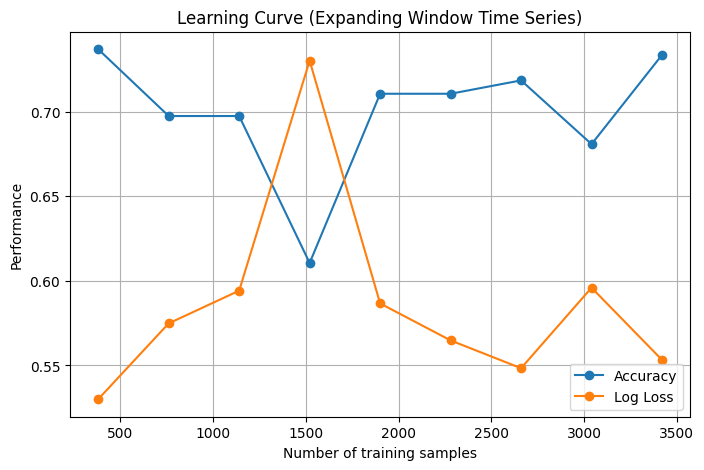

In [106]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(train_sizes, fold_accuracy, marker='o', label="Accuracy")
plt.plot(train_sizes, fold_logloss, marker='o', label="Log Loss")

plt.xlabel("Number of training samples")
plt.ylabel("Performance")
plt.title("Learning Curve (Expanding Window Time Series)")
plt.legend()
plt.grid(True)
plt.show()

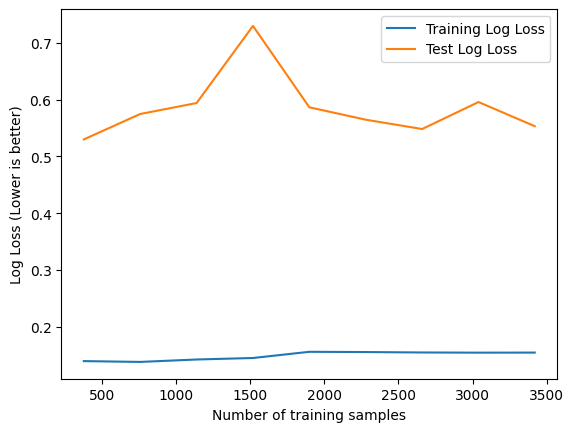

In [107]:
import matplotlib.pyplot as plt

plt.plot(train_sizes, train_scores, label="Training Log Loss")
plt.plot(train_sizes, test_scores, label="Test Log Loss")
plt.xlabel("Number of training samples")
plt.ylabel("Log Loss (Lower is better)")
plt.legend()
plt.show()

In [108]:
train_seasons = seasons[:-1]
test_season = seasons[-1]
train_seasons, test_season

(array([2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]), 2025)

In [109]:
model = RandomForestClassifier(
    n_estimators=500,
    max_depth=50,
    random_state=42,
    class_weight='balanced'
)

In [110]:
# Single model training
train_df = df[df["season"].isin(train_seasons)]
test_df = df[df["season"].isin([test_season])]

X_train = train_df[features]
y_train = train_df['target']
X_test = test_df[features]
y_test = test_df['target']

model.fit(X_train, y_train)

preds_test = model.predict(X_test)

prob_test = model.predict_proba(X_test)
y_pred = np.argmax(prob_test, axis=1)

print(f"RandomForstClassifier(n_estimators=500, max_depth=50) \n"
      f"Train({train_seasons}) with Test ({[test_season]} \n"
      f"Accuracy: {accuracy_score(y_test, preds_test)}, "
      f"Logloss: {log_loss(y_test, prob_test)}, "
      f"Precision: {precision_score(y_test, pred_labels, average='binary')}, "
      f"Recall: {recall_score(y_test, pred_labels, average='binary')}")

RandomForstClassifier(n_estimators=500, max_depth=50) 
Train([2016 2017 2018 2019 2020 2021 2022 2023 2024]) with Test ([2025] 
Accuracy: 0.7333333333333333, Logloss: 0.5533546087435315, Precision: 0.6129032258064516, Recall: 0.34545454545454546


In [111]:
failed_predictions_mask = y_pred != y_test.values
failed_prections = test_df.loc[failed_predictions_mask].copy()
failed_prections

,match_id,season,kickoff,home_team,home_team_id,home_score,away_team,away_team_id,away_score,outcome_label,...,home_pts_roll,away_gf_roll,away_ga_roll,away_pts_roll,h2h_avg_points_home,h2h_avg_points_away,rest_days_home,rest_days_away,rest_days_diff,target
3807,2561903,2025,2025-08-17 16:30:00,Manchester United,1,0,Arsenal,3,1,A,...,0.8,1.6,1.4,1.6,1.000000,1.750000,84.020833,84.020833,0.000000,1
3809,2561914,2025,2025-08-22 20:00:00,West Ham United,21,1,Chelsea,8,5,A,...,1.4,1.0,0.6,2.0,1.100000,1.700000,6.208333,5.250000,0.958333,1
3810,2561912,2025,2025-08-23 12:30:00,Manchester City,43,0,Tottenham Hotspur,6,2,A,...,2.6,1.0,1.8,0.8,1.350000,1.500000,6.791667,6.895833,-0.104167,1
3818,2561913,2025,2025-08-25 20:00:00,Newcastle United,4,2,Liverpool,14,3,A,...,1.0,2.0,2.2,1.0,0.444444,2.277778,9.312500,10.000000,-0.687500,1
3820,2561924,2025,2025-08-30 15:00:00,Wolverhampton Wanderers,39,2,Everton,11,3,A,...,0.2,1.6,0.4,2.4,1.714286,1.071429,7.000000,6.041667,0.958333,1
3822,2561923,2025,2025-08-30 15:00:00,Tottenham Hotspur,6,0,Bournemouth,91,1,A,...,1.2,1.2,1.6,1.2,2.062500,0.750000,7.104167,7.000000,0.104167,1
3823,2561922,2025,2025-08-30 15:00:00,Sunderland,56,2,Brentford,94,1,H_or_D,...,0.6,1.2,1.4,1.4,1.000000,1.000000,7.000000,7.000000,0.000000,0
3824,2561918,2025,2025-08-30 17:30:00,Leeds United,2,0,Newcastle United,4,0,H_or_D,...,0.8,0.8,1.0,0.8,1.500000,1.000000,7.000000,4.895833,2.104167,0
3826,2561921,2025,2025-08-31 14:00:00,Nottingham Forest,17,0,West Ham United,21,3,A,...,1.6,1.4,2.2,1.2,2.000000,1.000000,7.000000,8.750000,-1.750000,1
3828,2561915,2025,2025-08-31 19:00:00,Aston Villa,7,0,Crystal Palace,31,3,A,...,1.4,1.6,0.8,1.8,1.428571,1.428571,8.166667,7.208333,0.958333,1


In [112]:
failed_prections["y_true"] = y_test.values[failed_predictions_mask]
failed_prections["y_pred"] = y_pred[failed_predictions_mask]
failed_prections["confidence"] = prob_test.max(axis=1)[failed_predictions_mask]
print(f"Failed {len(failed_prections)} predictions out of {len(y_pred)}")

Failed 48 predictions out of 180


In [113]:
failed_prections["confidence"].mean()

0.6704583333333334

In [114]:
failed_predictions_teams = pd.concat((failed_prections["home_team"], failed_prections["away_team"]))

In [115]:
failed_predictions_teams.value_counts()

Tottenham Hotspur           8
West Ham United             7
Chelsea                     7
Everton                     7
Leeds United                6
Liverpool                   6
Crystal Palace              6
Manchester United           5
Sunderland                  5
Nottingham Forest           5
Newcastle United            4
Wolverhampton Wanderers     4
Aston Villa                 4
Fulham                      4
Bournemouth                 3
Brighton and Hove Albion    3
Burnley                     3
Brentford                   3
Manchester City             3
Arsenal                     3
Name: count, dtype: int64